# Re-creation of Johnson and Zhang experiments

Our main task in this workbook, using the tools we have developed thus far in previous notebooks, is to implement the stochastic variance reduced gradient (SVRG) descent technique of Johnson and Zhang (NIPS 2013), and re-create their numerical experiments.

__Contents:__

- <a href="#formulation">Formulation of algorithm</a>

- <a href="#implementation">SVRG implementation</a>

 - <a href="#imp_general">General-purpose SVRG</a>
 
 - <a href="#imp_chainer">SVRG for Chainer</a>

- <a href="#experiment">Overview of numerical experiments</a>

- <a href="#testing">Testing and empirical analysis</a>

 - <a href="#testing_linear">Running linear models ("convex" case)</a>
 - <a href="#testing_nonlinear">Running non-linear models ("non-convex" case)</a>
 - <a href="#testing_evaluation">Evaluation of performance</a>

___

<a id="formulation"></a>
## Formulation of algorithm

The context within which the SVRG algorithm was proposed is as follows.

The objective is minimization of a sum of real-valued functions with domain $\mathbb{R}^d$. Using our loss function notation, this is

\begin{align*}
\min_{w \in \mathbb{R}^{d}} F(w), \quad F(w) = \frac{1}{n} \sum_{i=1}^{n} L(w;z_{i}).
\end{align*}

Stochastic gradient descent (SGD), as <a href="Algo_FirstOrder.ipynb">introduced previously</a>, is a popular technique for solving this minimization task. SGD offers a low-cost approach to exploring parameter space while on average moving in the direction of a traditional (expensive) full-batch gradient descent update.

On the other hand, since SGD uses only one or very few examples per iteration, the algorithm does not tend to converge unless the step size $\alpha_{(t)} \to 0$ as $t \to \infty$. SGD does not converge on its own because of the sub-sampling induced variance. Strictly speaking, when we run SGD, we are running a single full-batch GD update for a different objective function at each step, pulling the parameter vector in different directions *ad infinitum*.

The basic idea of the authors is to propose a compromise:

- For the vast majority of iterations, compute gradients for a mini-batch of size $B \ll n$.
- For a small fraction of iterations, compute a full-batch gradient (size $n$), and use that valuable information to stabilize subsequent updates.

Their idea for stabilization is extremely simple, and it often works very well in practice. Let's get into the details.

The procedure takes a two-loop structure as follows. Initialize $\tilde{w}_{0}$. This is a "snapshot" vector that will be used as a reference in the inner loop. In the outer loop, we do full-batch computations. For each $s = 1,2,\ldots$, do the following:

0. $\tilde{w} = \tilde{w}_{(s-1)}$

0. $\displaystyle \tilde{g} = \frac{1}{n} \sum_{i=1}^{n} \nabla L(\tilde{w};z_{i})$

0. $w_{(0)} = \tilde{w}$

0. Run inner loop for $T$ steps, get $w_{(T)}$

0. Set $\tilde{w}_{s} = w_{(T)}$.

The core computation here is $\tilde{g}$. Given the finite-sum objective, this is the ideal update direction at $\tilde{w}$. The $w_{(0)}$ is simply an initialization for the inner loop. With this done, the procedure enters an inner loop. For each $t=0,1,\ldots,T$ do the following:

0. Randomly choose $I_{t} \in \{1,\ldots,n\}$
0. $\Delta_{t} = \nabla L(\tilde{w};z_{I_{t}}) - \tilde{g}$
0. Update as $\displaystyle w_{(t+1)} = w_{(t)} - \alpha \left(\nabla L(w_{(t)};z_{I}) - \Delta_{t} \right)$

This strategy is really very elegant in its simplicity and direct nature; $\Delta_{t}$ represents how far off the single-example estimator is from the desired update direction, for the "snapshot" $\tilde{w}$.

The core underlying assumption is that as long as the snapshot is updated relatively frequently, the deviation of the mini-batch estimator at $\tilde{w}$ will be similar to its deviation at $w_{(t)}$, for all steps in the inner loop.

Note also that, just as with SGD, when we condition on $w_{(t)}$, taking expectation with respect to the random choice of $I_{t}$, we have

\begin{align*}
\mathbf{E} \left( \nabla L(w_{(t)};z_{I_{t}}) - \Delta_{t} \right) & = \frac{1}{n} \sum_{i=1}^{n} L(w_{(t)};z_{i}) - \mathbf{E} \left( \nabla L(\tilde{w};z_{I_{t}}) - \tilde{g}\right)\\
& = \frac{1}{n} \sum_{i=1}^{n} L(w_{(t)};z_{i}).
\end{align*}

<a id="implementation"></a>
## SVRG implementation

Here we shall provide two implementations of SVRG. One will continue in the tradition of our <a href="Algo_FirstOrder.ipynb">previous hand-built algorithms</a> with `Algo_SVRG`, defined as a sub-class of `Algo_LineSearch`. The other will be an implementation adapted to neural network models developed using Chainer.

In [1]:
import math
import numpy as np
import chainer as ch
import matplotlib
import matplotlib.pyplot as plt

import algorithms
import models
import dataclass
import helpers as hlp

<a id="imp_general"></a>
### General-purpose SVRG

In [2]:
class Algo_SVRG(algorithms.Algo_LineSearch):
    '''
    Stochastic variance reduced gradient descent.
    '''
    def __init__(self, w_init, step, batchsize, replace,
                 out_max, in_max, thres, store, lamreg):

        super(Algo_SVRG, self).__init__(w_init=w_init,
                                        step=step,
                                        t_max=(out_max*in_max),
                                        thres=thres,
                                        store=store,
                                        lamreg=lamreg)
        self.out_max = out_max
        self.in_max = in_max
        self.batchsize = batchsize
        self.replace = replace

        # Computed internally.
        self.nseen = 0
        self.npasses = 0
        self.idx_inner = 0
        self.torecord = True


    def newdir(self, model, data):
        '''
        Determine the direction of the update.
        '''

        if self.idx_inner == 0:
            self.w_snap = np.copy(self.w)
            self.g_snap = np.mean(model.g_tr(w=self.w_snap,
                                             data=data,
                                             lamreg=self.lamreg),
                                  axis=0, keepdims=True)
        
        shufidx = np.random.choice(data.n_tr,
                                   size=self.batchsize,
                                   replace=self.replace)
        g_sgd = np.mean(model.g_tr(w=self.w,
                                   n_idx=shufidx,
                                   data=data,
                                   lamreg=self.lamreg),
                        axis=0, keepdims=True)
        correction = np.mean(model.g_tr(w=self.w_snap,
                                        n_idx=shufidx,
                                        data=data,
                                        lamreg=self.lamreg),
                             axis=0, keepdims=True) - self.g_snap
        return (-1) * (g_sgd-correction)


    def monitor_update(self, model, data):
        '''
        Update the counters and convergence
        monitors used by the algorithm. This is
        executed once every step.
        '''
        self.t += 1
        self.idx_inner += 1
        if self.idx_inner == self.in_max:
            self.idx_inner = 0

        # Check differences every "epoch" over data.
        self.nseen += self.batchsize
        if self.nseen >= data.n_tr:
            self.torecord = True
            self.npasses += 1
            self.diff = np.linalg.norm((self.w-self.w_old))
            self.w_old = np.copy(self.w)
            self.nseen = self.nseen % data.n_tr
            
    
    def cost_update(self, model, data):
        '''
        Update the amount of computational resources
        used by the routine.

        Cost computation based on number of gradients computed:
        - Each inner loop step requires mini-batch gradients for
          two vectors, w and w_snap.
        - Each outer loop step additionally requires a full
          batch of gradients.
        '''

        if self.idx_inner == self.in_max:
            self.stepcost = 2 * self.batchsize + data.n_tr
        else:
            self.stepcost = 2 * self.batchsize
            
        self.cumcost += self.stepcost


<a id="imp_chainer"></a>
### SVRG for Chainer


In [3]:
## Experiment setup.

# Data-related.
data = dataclass.DataSet() # Initialize one data object; will be re-populated at each trial.
n = 500 # sample size
d = 2 # number of parameters
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct
cov_X = np.eye(d) # covariance matrix of the inputs.

w_star = np.ones(d).reshape((d,1)) # vector specifying true model

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
out_max = 5
batchsize = 1
in_max = 50
t_max = out_max*in_max # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.05

# Clerical.
mth_names = ["svrg", "svrg-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [4]:
# Make choice of additive noise distribution (un-comment your choice).
#paras = {"name": "norm", "shift": 0.0, "scale": 20.0}
paras = {"name": "lnorm", "meanlog": 0.0, "sdlog": 1.75}

# Put together risk function.
def risk(w):
    mean_noise, var_noise = hlp.noise_risk(paras=paras)
    return hlp.riskMaker(w=w, A=cov_X, b=math.sqrt(var_noise), w_star=w_star)
risk_star = risk(w=w_star) # optimal risk value.

In [5]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
truedist = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Generate new data (with *centered* noise).
    X = np.random.normal(loc=0.0, scale=1.0, size=(n,d))
    noise = hlp.noise_data(n=n, paras=paras)
    y = np.dot(X, w_star) + noise
    data.init_tr(X=X, y=y)
    
    # Data for Chainer model.
    Z = ch.datasets.TupleDataset(np.float32(X),
                                 np.float32(y))
    
    # Initial weight settings.
    w_init = w_star + np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    
    # Initialize models (hand-built).
    mod_learner = models.LinearL2(data=data)
    risk_star = risk(w=w_star) # optimal risk value.
    loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
    
    # Initialize models (Chainer-based).
    mod_chainer = models.MyChain(out_l0=d,
                                 out_l1=1,
                                 init_W=w_init.T,
                                 init_b=None,
                                 init_delta=init_delta,
                                 nobias=True)
    
    mod_snap = models.MyChain(out_l0=d,
                              out_l1=1,
                              init_W=w_init.T,
                              init_b=None,
                              init_delta=init_delta,
                              nobias=True)
    
    # Initialize algorithms (hand-built).
    al_svrg = Algo_SVRG(w_init=w_init,
                        step=make_step(alphaval),
                        batchsize=batchsize,
                        replace=False,
                        out_max=out_max,
                        in_max=in_max,
                        thres=thres,
                        store=True,
                        lamreg=None)
    
    
    # Run all algorithms and save their performance.
    
    ## ERM-SVRG.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for mystep in al_svrg:
            al_svrg.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_svrg.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_svrg.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_svrg.w)-0
            idx += 1
        
    ## Replication of ERM-SVRG using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        t = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z,
                                                 batch_size=batchsize,
                                                 repeat=True,
                                                 shuffle=False)
        while t < t_max:
            
            # If condition holds, run "outer loop" update.
            if t % in_max == 0:
                
                # Use the output of "inner loop" as new snapshot.
                mod_snap = mod_chainer.copy(mode="copy")
                
                # Use the full data set here.
                X_batch, y_batch = ch.dataset.concat_examples(Z)
                prediction_tr_snap = mod_snap(X_batch)
                
                # Compute loss and full-batch gradient.
                loss_snap = ch.functions.mean_squared_error(prediction_tr_snap, y_batch) / 2.0
                mod_snap.cleargrads()
                loss_snap.backward()
                
                # Store the gradient list for use in inner loop.
                grad_list = [np.copy(p.grad) for p in mod_snap.params()]
            
            
            # Mini-batch computations for inner loop.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)
            t += 1 # manage steps ourselves.
            
            # Predictions.
            prediction_tr = mod_chainer(X_batch)
            prediction_tr_snap = mod_snap(X_batch)

            # Loss computations (will feed the grad computations).
            loss = ch.functions.mean_squared_error(prediction_tr, y_batch) / 2.0
            loss_snap = ch.functions.mean_squared_error(prediction_tr_snap, y_batch) / 2.0
            #old_loss = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))
            
            # Gradient computations.
            mod_chainer.cleargrads()
            mod_snap.cleargrads()
            loss.backward()
            loss_snap.backward()
            
            # Parameter updates.
            zipped = zip(mod_chainer.params(), mod_snap.params(), grad_list)
            for p, p_snap, mu in zipped:
                grad = p.grad
                grad_snap = p_snap.grad
                if grad is None:
                    continue
                else:
                    adjust = grad_snap - mu
                    p.data -= alphaval * (grad-adjust)

            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))-np.mean(mod_learner.l_tr(w=w_star, data=data))
            riskvals[tri,idx,mthidx] = risk(w=mod_chainer.l1.W.data.T)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-mod_chainer.l1.W.data.T)-0
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
ave_truedist = np.mean(truedist, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)
sd_truedist = np.std(truedist, axis=0)

__Exercises:__

0. What is the role of `mod_snap` versus `mod_chainer`?

0. What is going on in the iteration over `zipped`?

0. Do you expect the performance of Chainer-based ERM-SVRG to be identical to the hand-made ERM-SVRG? Why or why not?

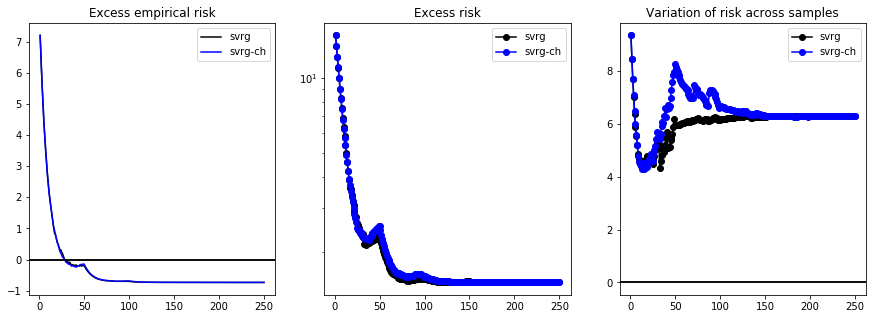

In [7]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    #ax_loss_tr.errorbar(tvals, vals, yerr=err, fmt='-o', col=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess empirical risk")
    

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.semilogy(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess risk")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of risk across samples")


plt.show()

Great. The behaviour is essentially the same. Since the bootstrapped samples are selected randomly and independently across the two implementations, there is naturally some minor deviation in behaviour, but on the whole they perform identically, verifying with relative certainty that the Chainer-based optimizer indeed behaves as we would expect.

___

<a id="experiment"></a>
## Overview of numerical experiments

In this section, we dig in to the details of the numerical experiments of Johnson and Zhang (2013). In the following section, we will actually implement the various experiments. Their experiments involve several real-world data sets, all well-known benchmarks used frequently in machine learning. In particular, they evaluate three quantities:

- Training loss
- Testing loss
- Update variance

These quantities are evaluated as a function of *cost*, which is the number of $d$-dimensional gradient vectors computed. The basic form of their results is as below:

<img src="img/JZ_exps_example.png"  alt="Example figures from Johnson and Zhang (NIPS 2013)" />

Their experimental setup considers *classification* tasks only, 
They basically consider two distinct experimental settings, exploring the same data sets under both settings:

- Convex: traditional logistic regression is used; the objective is a convex function in the linear weights.
- Non-convex: a feed-forward neural network with one fully-connected hidden layer, sigmoid activation, and softmax output nodes for each class. The mini-batch size is 10. The resulting logistic regression is not convex as a function of the network weights.

On variance computation:

> In Fig. 2 (c), we show the variance of SVRG update $-\eta (\nabla \psi_{i}(w)-\psi_{i}(\tilde{w})+\tilde{\mu})$ in comparison with the variance of SGD update $-\eta(\nabla \psi_{i}(w))$ and SDCA. As expected, the variance (including multiplication with the learning rate) of both SVRG and SDCA decreases as optimization proceeds, and the variance of SGD with a fixed learning rate (‘SGD:0.001’) stays high.

Some key additional facts:

- Inner loop max iterations: $2n$ (convex) and $5n$ (non-convex).

- Initialization of SVRG: by running SGD for one iteration (convex) or ten iterations (non-convex).

- All tests used $\ell_{2}$ norm-based regularization, with weights depending on the data set used: 1e-4 for MNIST, 1e-3 for CIFAR-10, in both convex and non-convex settings.

- Learning rates are displayed in the papers in the Figure.


___

<a href="#testing"></a>
## Testing and empirical analysis

Here is where we run the actual experiments. Below, we have completed preliminary implementations of SVRG in the convex (multi-class logistic regression) and non-convex (feed-forward neural network + softmax) cases. Using this code as a guide, carry out the following __exercises__:

0. Parameters such as learning rate, regularization weight, number of inner/outer loop iteration etc., are set arbitrarily in the code below. Modify these to match the paper.

0. In the non-convex case, we have only implemented SVRG. Implement SGD in the non-convex case and compare performance.

0. How has $\ell_{2}$ norm-based regularization been implemented in our non-convex implementation?

0. How is "variance" computed in our non-convex implementation?

0. Learning rate scheduling for SGD has not been implemented (only fixed learning rates); implement this and compute the performance of what they call "SGD-best" (based on a grid of hyper-parameters).

In [10]:
import os
import tables
import numpy as np
import multiprocessing as mltp

import dataclass
import algorithms
import helpers as hlp
import models

In [11]:
# Data set choice.

paths = {
    "cifar10": os.path.join("data", "cifar10", "data.h5"),
    "mnist": os.path.join("data", "MNIST", "data.h5"),
    "iris": os.path.join("data", "iris", "data.h5")
}

task_name = "iris" # SET BY HAND.

In [12]:
# General-purpose performance evaluation.
def perf_fn(model=None, algo=None, data=None):
    '''
    Performance measurement routine.
    Various metrics are computed, relevant descriptions
    are given as names, and both are returned together
    in a dictionary.
    '''

    names = ["Misclass rate (train)",
             "Misclass rate (test)",
             "Primal objective (train)",
             "Primal objective (test)",
             "Norm (l2)"]

    # In the case of a dry run, leave perf Null.
    if ((model is None) or (algo is None)):
        return {"names": names, "perf": None}

    # Else, compute the performance metrics of interest.
    y_est_tr = model.classify(w=algo.w, X=data.X_tr)
    y_est_te = model.classify(w=algo.w, X=data.X_te)

    perf_tr = model.class_perf(y_est=y_est_tr, y_true=data.y_tr)
    perf_te = model.class_perf(y_est=y_est_te, y_true=data.y_te)

    misclass_tr = perf_tr["rate"]
    misclass_te = perf_te["rate"]
    
    primal_tr = np.mean(model.l_tr(w=algo.w, data=data))
    primal_te = np.mean(model.l_te(w=algo.w, data=data))

    w_norm = np.linalg.norm(algo.w)
    
    perf = np.array([misclass_tr, misclass_te,
                     primal_tr, primal_te,
                     w_norm])
    
    out = {"names": names,
           "perf": perf}
    
    return out


# Performance evaluation for Chainer-based implementation.
def perf_fn_ch(model=None, data=None):
    '''
    Performance measurement routine; Chainer version.
    Various metrics are computed, relevant descriptions
    are given as names, and both are returned together
    in a dictionary.
    
    NOTE: the "model" here contains all parameters.
    '''
    
    names = ["Misclass rate (train)",
             "Misclass rate (test)",
             "Primal objective (train)",
             "Primal objective (test)",
             "Norm (l2)"]

    # In the case of a dry run, leave perf Null.
    if (model is None or data is None):
        return {"names": names, "perf": None}

    # Else, compute the performance metrics of interest.
    
    ## Get predictions (not tuple notation).
    prediction_tr = model(data.X_tr)
    prediction_te = model(data.X_te)
    
    ## Compute misclassification rate.
    accuracy_tr = ch.functions.accuracy(y=prediction_tr,
                                        t=np.int8(data.y_tr).flatten()).data
    accuracy_te = ch.functions.accuracy(y=prediction_te,
                                        t=np.int8(data.y_te).flatten()).data
    misclass_tr = 1-accuracy_tr
    misclass_te = 1-accuracy_te
    
    ## Compute loss function values.
    primal_tr = ch.functions.softmax_cross_entropy(x=prediction_tr,
                                                   t=np.int8(data.y_tr).flatten(),
                                                   normalize=True,
                                                   reduce="mean").data
    
    primal_te = ch.functions.softmax_cross_entropy(x=prediction_te,
                                                   t=np.int8(data.y_te).flatten(),
                                                   normalize=True,
                                                   reduce="mean").data
    
    ## Finally compute the norm.
    w_norm = 0
    for p in model.params():
        w_norm += np.linalg.norm(p.data)**2
    w_norm = math.sqrt(w_norm)
    
    
    perf = np.array([misclass_tr, misclass_te,
                     primal_tr, primal_te,
                     w_norm])
    
    out = {"names": names,
           "perf": perf}
    
    return out

<a id="testing_linear"></a>
### Running linear models ("convex" case)


In [13]:
# Basically a "driver script" for our hand-built guys.

num_trials = 5

# Prepare a results folder, if doesn't already exist.
hlp.makedir_safe(os.path.join("results", task_name))

# Establish file connection.
toread = paths[task_name]
f = tables.open_file(toread, mode="r")

# Prepare data object.
data = dataclass.DataSet()
data.init_tr(X=f.root.train.inputs.read(),
             y=f.root.train.labels.read())
data.init_te(X=f.root.test.inputs.read(),
             y=f.root.test.labels.read())

In [14]:
# Prepare model object.
mod = models.LogisticReg(data=data)

# Initialize all competing hand-built algorithms.
n, numfeats = data.X_tr.shape
nc = mod.nc
d = numfeats * (nc-1)

In [15]:
perf_names = perf_fn()["names"] # fire a blank to get metric names.
num_metrics = len(perf_names) # number of perf metrics used.

In [16]:
# Algorithm preparation.

num_epochs = 10
replace = False
thres = 1e-03
store = False
lamreg = 1e-03 # should adjust depending on data set.

def alpha_fixed(t, val):
    return val

def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep

def algoFn_sgd(w_init):
    al = algorithms.Algo_SGD(w_init=w_init,
                             step=make_step(u=0.01),
                             batchsize=1,
                             replace=replace,
                             t_max=num_epochs*n,
                             thres=thres,
                             store=store,
                             lamreg=lamreg)
    return al

def algoFn_svrg(w_init):
    al = algorithms.Algo_SVRG(w_init=w_init,
                              step=make_step(u=0.1),
                              batchsize=1,
                              replace=replace,
                              out_max=num_epochs/2,
                              in_max=2*n,
                              thres=thres,
                              store=store,
                              lamreg=lamreg)
    return al

algoFn_dict = {"sgd": algoFn_svrg,
               "svrg": algoFn_sgd}

In [17]:
# Max number of perf records.
max_records = num_epochs + 1 # extra one for initial values.

In [18]:
# Run the algorithms, and write performance to disk.

def worker(algorithm_name):
    
    print("At work:", algorithm_name)
    
    # Array used for recording cumulative costs.
    perf_cumcost = np.zeros(max_records, dtype=np.uint32)
    perf_cumcost.fill(np.nan)

    # Array used for recording update variance.
    perf_updatevar = np.zeros(max_records, dtype=np.float32)
    perf_updatevar.fill(np.nan)

    # Array used for housing performance over trials.
    perf_array = np.zeros((max_records, num_metrics, num_trials),
                          dtype=np.float32)
    perf_array.fill(np.nan)
    
    for tri in range(num_trials):

        # Initialize weights and algorithm here.
        w_init = np.random.uniform(low=0.0, high=0.1, size=(d,1))
        al = algoFn_dict[algorithm_name](w_init=w_init)

        cntr = 0
        for onestep in al:

            if al.t % 5000 == 0:
                print("Update: t =", al.t)

            al.update(model=mod, data=data) # update parameters.

            if al.torecord:
                al.torecord = False # switch off.
                perf_updatevar[cntr] = al.diff
                perf_array[cntr,:,tri] = perf_fn(model=mod,
                                                 algo=al,
                                                 data=data)["perf"]
                perf_cumcost[cntr] = al.cumcost
                cntr += 1

        # Finally, if cntr isn't already maxed out, be sure
        # to record performance at the final step.
        if cntr < max_records:
            perf_updatevar[cntr] = np.linalg.norm(al.w-al.w_old)
            perf_array[cntr,:,tri] = perf_fn(model=mod,
                                             algo=al,
                                             data=data)["perf"]
            perf_cumcost[cntr] = al.cumcost

    # Having run over all trials, compute statistics.
    # note: ndarray shape is (max_records, num_metrics).
    perf_ave = np.mean(perf_array, axis=2)
    perf_sd = np.std(perf_array, axis=2)

    # Trim the unfilled results (as needed).
    tocheck = np.where(np.isnan(perf_ave[:,0]))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_ave = perf_ave[0:badidx,:]

    tocheck = np.where(np.isnan(perf_sd[:,0]))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_sd = perf_sd[0:badidx,:]

    tocheck = np.where(np.isnan(perf_cumcost))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_cumcost = perf_cumcost[0:badidx,:]

    tocheck = np.where(np.isnan(perf_updatevar))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_updatevar = perf_updatevar[0:badidx]

    # Write to disk.
    towrite = os.path.join("results", task_name)
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".cost")),
               X=perf_cumcost, fmt="%d", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".upvar")),
               X=perf_updatevar, fmt="%.7e", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".ave")),
               X=perf_ave, fmt="%.7e", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".sd")),
               X=perf_sd, fmt="%.7e", delimiter=",")


In [19]:
if __name__ == "__main__":
    cpu_count = mltp.cpu_count()
    print("Our machine has", cpu_count, "CPUs.")
    print("Of these,", len(os.sched_getaffinity(0)), "are available.")
            
    # Put all processors to work (at an upper limit).
    mypool = mltp.Pool(cpu_count)
    
    # Pass the "worker" the name of the algorithm to run.
    mypool.map(func=worker, iterable=algoFn_dict.keys())

    # Memory management.
    mypool.close() # important for stopping memory leaks.
    mypool.join() # wait for all workers to exit.
    
    # END of multiproc procedure.

Our machine has 12 CPUs.
Of these, 12 are available.
At work: svrg
At work: sgd
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0


In [20]:
# Close file connection.
f.close()

<a id="testing_nonlinear"></a>
### Running non-linear models ("non-convex" case)

Here is where we do essentially the same thing as above, except instead of using our customized models and optimizers, we make use of Chainer to expediate the implementation process.

Let's implement their non-linear model, in the sub-class `Chain_JZ`.

In [21]:
class Chain_JZ(ch.Chain):
    '''
    The neural network used by Johnson and Zhang (2013).
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 out_l2,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_JZ, self).__init__()
        
        with self.init_scope():
            self.l1 = models.Linear(in_size=out_l0,
                                    out_size=out_l1,
                                    init_W=None,
                                    init_b=None,
                                    init_delta=init_delta,
                                    nobias=True)
            self.l2 = models.Linear(in_size=out_l1,
                                    out_size=out_l2,
                                    init_W=None,
                                    init_b=None,
                                    init_delta=init_delta,
                                    nobias=True)
        
    def __call__(self, x):
        out = ch.functions.sigmoid(self.l1(x)) # logistic sigmoid.
        out = self.l2(out) # return the un-normalized log-probabilities.
        return out

In [22]:
# Basically a "driver script" for our CHAINER-built guys.

num_trials = 5

# Prepare a results folder, if doesn't already exist.
hlp.makedir_safe(os.path.join("results", task_name))

# Establish file connection.
toread = paths[task_name]
f = tables.open_file(toread, mode="r")
    
# Prepare data object for Chainer.
Z_tr = ch.datasets.TupleDataset(np.float32(f.root.train.inputs.read()),
                                np.int8(f.root.train.labels.read()))

data = dataclass.DataSet()
data.init_tr(X=f.root.train.inputs.read(),
             y=f.root.train.labels.read())
data.init_te(X=f.root.test.inputs.read(),
             y=f.root.test.labels.read())

In [23]:
n, numfeats = data.X_tr.shape
nc = len(np.unique(data.y_tr))
d = numfeats * (nc-1)

In [24]:
perf_names = perf_fn_ch()["names"] # fire a blank to get metric names.
num_metrics = len(perf_names) # number of perf metrics used.

In [25]:
# Algorithm preparation.
num_epochs = 10
replace = False
thres = 1e-03
store = False
lamreg = 1e-03 # should adjust depending on data set.
alphaval = 0.05

in_max = n
out_max = num_epochs
t_max = out_max * in_max

al_name = "svrg-ch"

In [26]:
# Max number of perf records.
max_records = num_epochs + 1 # extra one for initial values.

In [27]:
# Run the algorithms, and write performance to disk.

# Array used for recording cumulative costs.
perf_cumcost = np.empty(max_records)
perf_cumcost.fill(np.nan)

# Array used for recording update variance.
perf_updatevar = np.empty(max_records)
perf_updatevar.fill(np.nan)

# Array used for housing performance over trials.
perf_array = np.zeros((max_records, num_metrics, num_trials))
perf_array.fill(np.nan)

for tri in range(num_trials):
    
    # Initialize models (Chainer-based).
    mod_svrg = Chain_JZ(out_l0=numfeats,
                        out_l1=100,
                        out_l2=nc,
                        nobias=True)
    
    mod_snap = Chain_JZ(out_l0=numfeats,
                        out_l1=100,
                        out_l2=nc,
                        nobias=True)
    
    # Execution of SVRG.
    idx = 0
    cntr = 0
    cumcost = 0
    t = 0
    iter_train = ch.iterators.SerialIterator(dataset=Z_tr,
                                             batch_size=1,
                                             repeat=True,
                                             shuffle=True)
    
    while t < t_max:
        
        # If condition holds, run "outer loop" update.
        if t % in_max == 0:
            
            # Turn on the "to record" flag.
            torecord = True
            
            # Use the output of "inner loop" as new snapshot.
            mod_snap = mod_svrg.copy(mode="copy")
            
            # Use the full data set here.
            prediction_tr_snap = mod_snap(data.X_tr)

            # Compute loss and full-batch gradient.
            loss_snap = ch.functions.softmax_cross_entropy(x=prediction_tr_snap,
                                                           t=np.int8(data.y_tr).flatten(),
                                                           normalize=True,
                                                           reduce="mean")
            mod_snap.cleargrads()
            loss_snap.backward()
            
            # Store the gradient list for use in inner loop.
            grad_list = [np.copy(p.grad) for p in mod_snap.params()]
            
            # Update cumulative cost.
            cumcost += data.X_tr.shape[0]
        
        # In any case, run typical "inner loop" update.
        
        ## Mini-batch computations for inner loop.
        Z = iter_train.next()
        X, y = ch.dataset.concat_examples(Z)
        t += 1 # manage steps ourselves.
        
        ## Predictions.
        prediction_tr = mod_svrg(X)
        prediction_tr_snap = mod_snap(X)
        
        ## Loss computations (will feed the grad computations).
        loss = ch.functions.softmax_cross_entropy(x=prediction_tr,
                                                  t=y.flatten(),
                                                  normalize=True,
                                                  reduce="mean")
        
        loss_snap = ch.functions.softmax_cross_entropy(x=prediction_tr_snap,
                                                       t=y.flatten(),
                                                       normalize=True,
                                                       reduce="mean")
        
        ## Gradient computations.
        mod_svrg.cleargrads()
        mod_snap.cleargrads()
        loss.backward()
        loss_snap.backward()
        
        ## Update cumulative cost.
        cumcost += 2
        
        # Prepare fresh update variance (squared).
        upvar_sq = 0 
        
        ## Parameter updates.
        zipped = zip(mod_svrg.params(), mod_snap.params(), grad_list)
        for p, p_snap, mu in zipped:
            grad = p.grad
            grad_snap = p_snap.grad
            if grad is None:
                continue
            else:
                adjust = grad_snap - mu
                p.data *= (1-2*lamreg*alphaval) # this is l2-squared regularization.
                p.data -= alphaval * (grad-adjust)
                upvar_sq += np.linalg.norm(alphaval*(grad-adjust))**2
        
        ## Record performance.
        if torecord:
            torecord = False # switch off.
            perf_updatevar[cntr] = math.sqrt(upvar_sq)
            perf_array[cntr,:,tri] = perf_fn_ch(
                model=mod_svrg,
                data=data
            )["perf"]
            perf_cumcost[cntr] = cumcost
            cntr += 1
            
            
# Having run over all trials, compute statistics.
# note: ndarray shape is (max_records, num_metrics).
perf_ave = np.mean(perf_array, axis=2)
perf_sd = np.std(perf_array, axis=2)

# Trim the unfilled results (as needed).
tocheck = np.where(np.isnan(perf_ave[:,0]))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_ave = np.float32(perf_ave[0:badidx,:])

tocheck = np.where(np.isnan(perf_sd[:,0]))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_sd = np.float32(perf_sd[0:badidx,:])

tocheck = np.where(np.isnan(perf_cumcost))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_cumcost = np.uint32(perf_cumcost[0:badidx])

tocheck = np.where(np.isnan(perf_updatevar))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_updatevar = np.float32(perf_updatevar[0:badidx])

# Write to disk.
towrite = os.path.join("results", task_name)
np.savetxt(fname=os.path.join(towrite, (al_name+".cost")),
            X=perf_cumcost, fmt="%d", delimiter=",")
np.savetxt(fname=os.path.join(towrite, (al_name+".upvar")),
            X=perf_updatevar, fmt="%.7e", delimiter=",")
np.savetxt(fname=os.path.join(towrite, (al_name+".ave")),
            X=perf_ave, fmt="%.7e", delimiter=",")
np.savetxt(fname=os.path.join(towrite, (al_name+".sd")),
           X=perf_sd, fmt="%.7e", delimiter=",")



In [28]:
# Close file connection.
f.close()

<a id="testing_evaluation"></a>
### Evaluation of performance

Having saved the results to disk, let us process and visualize them.

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import os

In [30]:
perf_names = perf_fn()["names"] # fire a blank to get metric names.
num_metrics = len(perf_names) # number of perf metrics used.

In [31]:
# Task name is fixed throughout all the tests below. Make sure we're consistent.
task_name = "iris"

perf_names = perf_fn()["names"] # fire a blank to get metric names.

results_dir = os.path.join("results", task_name) # Parent dir of all results.

# A few lines of code to extract all the method names.
names_results = os.listdir(results_dir)
names_methods = []
for s in names_results:
    tmp_split = s.split(".")[0:-1]
    names_methods += [".".join(tmp_split)]
        
names_methods = np.array(names_methods)
names_methods = np.unique(names_methods) # Clean out duplicates.
print("Names of methods to select from:")
print(names_methods)


Names of methods to select from:
['sgd' 'svrg' 'svrg-ch']


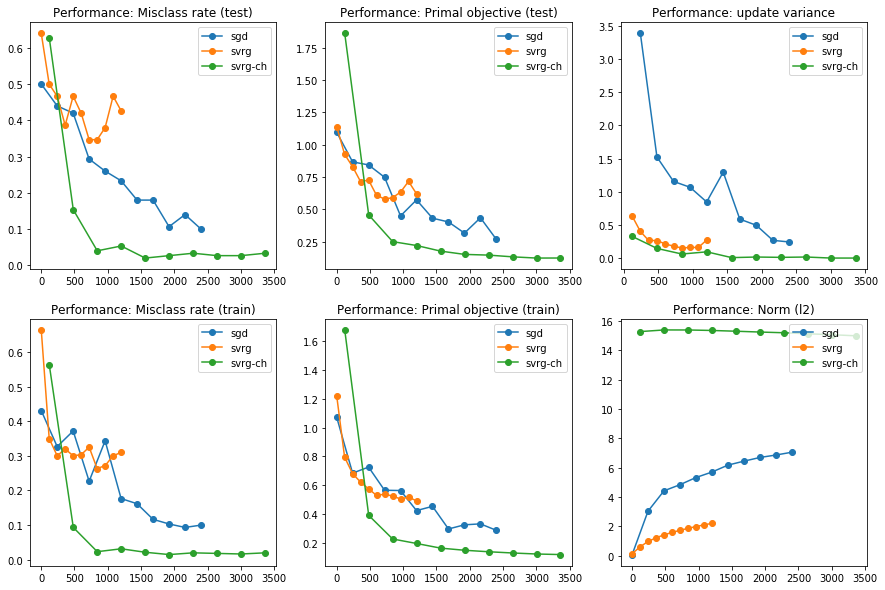

In [32]:

myfig = plt.figure(figsize=(15,10))


ax = myfig.add_subplot(2,3,1)
perf_idx = 1
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    
ax = myfig.add_subplot(2,3,2)
perf_idx = 3
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    
ax = myfig.add_subplot(2,3,3)
perf_idx = None
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")

    toread = os.path.join(results_dir, (al_name+".upvar"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_upvar = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_upvar, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: update variance")
    
    
ax = myfig.add_subplot(2,3,4)
perf_idx = 0
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    
ax = myfig.add_subplot(2,3,5)
perf_idx = 2
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    

ax = myfig.add_subplot(2,3,6)
perf_idx = 4
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])


plt.show()

___
